# Lab 12 - Creating an End-To-End Dialogue System

In the last lab we want to create end-to-end dialogue systems, following on from the seq2seq MT labs you've done. Customer support apps and online helpdesks are among the places where conversational models can be used. Retrieval-based models, which produce predefined responses to questions of specific types, are often used to power these models. In this lab, the seq2seq model is used to build a generative model.

To begin, download the data ZIP file from [here](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) and place it under the current directory. 

After that, let’s import some necessities.

In [ ]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive")

Mounted at /content/drive


In [ ]:
try:
  os.mkdir('NNandNLP-LAB12')
except:
  pass
os.chdir("NNandNLP-LAB12")

In [ ]:
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

--2022-04-27 21:10:07--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  13.3MB/s    in 0.7s    

2022-04-27 21:10:08 (13.3 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



In [ ]:
!unzip cornell_movie_dialogs_corpus.zip

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-dialogs corpus/movie_characters_metadata.txt  
  inflating: cornell movie-dialogs corpus/movie_conversations.txt  
  inflating: cornell movie-dialogs corpus/movie_lines.txt  
  inflating: cornell movie-dialogs corpus/movie_titles_metadata.txt  
  inflating: cornell movie-dialogs corpus/raw_script_urls.txt  
  inflating: cornell movie-dialogs corpus/README.txt  
  inflating: __MACOSX/cornell movie-dialogs corpus/._README.txt  


# The Cornell Movie-Dialogs Corpus 

The next move is to reformat our data file and load the data into functional structures. 

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [ ]:
#Loading the data
lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [ ]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [ ]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs. 
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [ ]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [ ]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

We are going to create a dataset of pairs without the trimmed words.

In [ ]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [ ]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

 : [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [ ]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

# Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'


--2022-04-27 21:19:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-27 21:19:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-27 21:19:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip 'glove.6B.zip'

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loded!


# Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



# Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

***For the first task you need to define a bidirectional GRU and pass the embedding into the GRU. ***

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units

        #  pass the embedding into a bidirectional version of the GRU - as you can see in the call() method below, you can use just 1 GRU layer but could experiment with more

        self.embeddings = embeddings
        self.Bidirectional1 = Bidirectional(GRU(units=self.enc_units, return_sequences=True))
        self.Bidirectional2 = Bidirectional(GRU(units=self.enc_units, return_sequences=True, return_state=True))


        #                                                                                        
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f,state_b = self.Bidirectional2(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [ ]:
encoder = Encoder(vocab_len, 50, GRU_units)


# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # Create the decoder with attention - as you'll see in the call() method below, it will need two GRU layers

        self.decoder_gru_l1 = GRU(self.units, return_sequences=True, name = 'Decoder_GRU_l1')
        self.decoder_gru_l2 = GRU(self.units, return_state=True, name = 'Decoder_GRU_l2')
        self.dropout = Dropout(0.2)
        self.attention = BahdanauAttention(self.units)


        
    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_len, 50, GRU_units)


# Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [ ]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

# Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties. 

In [ ]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

# Training procedure

# Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [ ]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


# Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 150 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [ ]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

# Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

Epoch 1 Batch 598 Loss: 2.0932
Epoch 1 Batch 1196 Loss: 2.3539
Epoch 1 Batch 1794 Loss: 2.1622
Epoch 1 Batch 2392 Loss: 2.1678
Epoch 1 Batch 2990 Loss: 1.9235
Epoch 1 Batch 3588 Loss: 2.3032

*** Epoch 1 Loss 2.1095 ***

####################
Greedy| Q: Hello   A: i am not you 
%
Greedy| Q: How are you ?  A: i am not you 
%
Greedy| Q: What are you doing ?  A: i am not you 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
####################
check point saved!
Best epoch so far:  1
Time  206.007 sec

Epoch 2 Batch 598 Loss: 1.7598
Epoch 2 Batch 1196 Loss: 2.4069
Epoch 2 Batch 1794 Loss: 2.3109
Epoch 2 Batch 2392 Loss: 2.3327
Epoch 2 Batch 2990 Loss: 1.7597
Epoch 2 Batch 3588 Loss: 2.2111

*** Epoch 2 Loss 1.8729 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am n

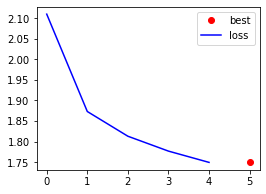

Best epoch so far:  5
Time  157.532 sec

Epoch 6 Batch 598 Loss: 1.5386
Epoch 6 Batch 1196 Loss: 1.8914
Epoch 6 Batch 1794 Loss: 1.7898
Epoch 6 Batch 2392 Loss: 1.9195
Epoch 6 Batch 2990 Loss: 1.6390
Epoch 6 Batch 3588 Loss: 1.9834

*** Epoch 6 Loss 1.7274 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  6
Time  158.194 sec

Epoch 7 Batch 598 Loss: 1.6613
Epoch 7 Batch 1196 Loss: 2.1535
Epoch 7 Batch 1794 Loss: 2.0887
Epoch 7 Batch 2392 Loss: 2.1689
Epoch 7 Batch 2990 Loss: 1.5305
Epoch 7 Batch 3588 Loss: 1.9832

*** Epoch 7 Loss 1.7104 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant

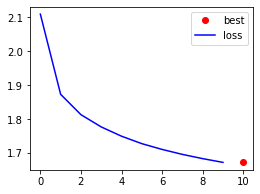

Best epoch so far:  10
Time  156.060 sec

Epoch 11 Batch 598 Loss: 1.4886
Epoch 11 Batch 1196 Loss: 1.8252
Epoch 11 Batch 1794 Loss: 1.6661
Epoch 11 Batch 2392 Loss: 1.9161
Epoch 11 Batch 2990 Loss: 1.5786
Epoch 11 Batch 3588 Loss: 1.9233

*** Epoch 11 Loss 1.6618 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  11
Time  155.550 sec

Epoch 12 Batch 598 Loss: 1.6396
Epoch 12 Batch 1196 Loss: 2.0424
Epoch 12 Batch 1794 Loss: 1.9166
Epoch 12 Batch 2392 Loss: 2.1166
Epoch 12 Batch 2990 Loss: 1.4428
Epoch 12 Batch 3588 Loss: 1.8462

*** Epoch 12 Loss 1.6534 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i a

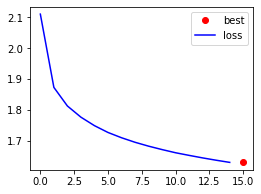

Best epoch so far:  15
Time  156.057 sec

Epoch 16 Batch 598 Loss: 1.4235
Epoch 16 Batch 1196 Loss: 1.8485
Epoch 16 Batch 1794 Loss: 1.6555
Epoch 16 Batch 2392 Loss: 1.9408
Epoch 16 Batch 2990 Loss: 1.6071
Epoch 16 Batch 3588 Loss: 1.7876

*** Epoch 16 Loss 1.6243 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to be a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not going to be a lot of other peoples 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a lot of the way 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  16
Time  156.413 sec

Epoch 17 Batch 598 Loss: 1.5174
Epoch 17 Batch 1196 Loss: 1.7507
Epoch 17 Batch 1794 Loss: 1.6997
Epoch 17 Batch 2392 Loss: 1.8144
Epoch 17 Batch 2990 Loss: 1.5397
Epoch 17 Batch 3588 Loss: 1.6059

*** Epoch 17 Loss 1.6180 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?

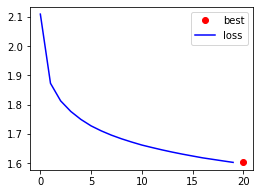

Best epoch so far:  20
Time  156.643 sec

Epoch 21 Batch 598 Loss: 1.3870
Epoch 21 Batch 1196 Loss: 1.9163
Epoch 21 Batch 1794 Loss: 1.7824
Epoch 21 Batch 2392 Loss: 1.9449
Epoch 21 Batch 2990 Loss: 1.6256
Epoch 21 Batch 3588 Loss: 1.8556

*** Epoch 21 Loss 1.5978 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to be a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not going to be a lot of things 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  21
Time  155.974 sec

Epoch 22 Batch 598 Loss: 1.4547
Epoch 22 Batch 1196 Loss: 1.7411
Epoch 22 Batch 1794 Loss: 1.6558
Epoch 22 Batch 2392 Loss: 1.8277
Epoch 22 Batch 2990 Loss: 1.4696
Epoch 22 Batch 3588 Loss: 1.6384

*** Epoch 22 Loss 1.5930 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to be a lot of t

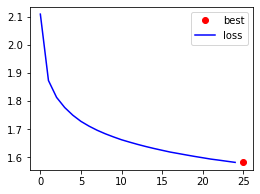

Best epoch so far:  25
Time  155.879 sec

Epoch 26 Batch 598 Loss: 1.4193
Epoch 26 Batch 1196 Loss: 1.9755
Epoch 26 Batch 1794 Loss: 1.8886
Epoch 26 Batch 2392 Loss: 1.8357
Epoch 26 Batch 2990 Loss: 1.6413
Epoch 26 Batch 3588 Loss: 1.9261

*** Epoch 26 Loss 1.5776 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not going to be a lot of things 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  26
Time  156.449 sec

Epoch 27 Batch 598 Loss: 1.4620
Epoch 27 Batch 1196 Loss: 1.7469
Epoch 27 Batch 1794 Loss: 1.5836
Epoch 27 Batch 2392 Loss: 1.8358
Epoch 27 Batch 2990 Loss: 1.4684
Epoch 27 Batch 3588 Loss: 1.6972

*** Epoch 27 Loss 1.5741 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greed

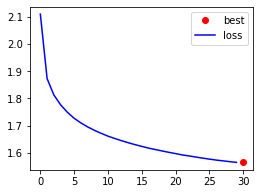

Best epoch so far:  30
Time  156.164 sec

Epoch 31 Batch 598 Loss: 1.2769
Epoch 31 Batch 1196 Loss: 2.0882
Epoch 31 Batch 1794 Loss: 1.8385
Epoch 31 Batch 2392 Loss: 1.9266
Epoch 31 Batch 2990 Loss: 1.5966
Epoch 31 Batch 3588 Loss: 1.9610

*** Epoch 31 Loss 1.5629 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to be a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  31
Time  155.809 sec

Epoch 32 Batch 598 Loss: 1.3936
Epoch 32 Batch 1196 Loss: 1.7968
Epoch 32 Batch 1794 Loss: 1.5927
Epoch 32 Batch 2392 Loss: 1.8681
Epoch 32 Batch 2990 Loss: 1.5020
Epoch 32 Batch 3588 Loss: 1.6598

*** Epoch 32 Loss 1.5598 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you do

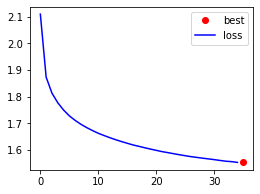

Best epoch so far:  35
Time  155.936 sec

Epoch 36 Batch 598 Loss: 1.3163
Epoch 36 Batch 1196 Loss: 2.1018
Epoch 36 Batch 1794 Loss: 1.8121
Epoch 36 Batch 2392 Loss: 1.9221
Epoch 36 Batch 2990 Loss: 1.6015
Epoch 36 Batch 3588 Loss: 1.8543

*** Epoch 36 Loss 1.5501 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to be a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not going to be a lot of things 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  36
Time  156.336 sec

Epoch 37 Batch 598 Loss: 1.3554
Epoch 37 Batch 1196 Loss: 1.8525
Epoch 37 Batch 1794 Loss: 1.7333
Epoch 37 Batch 2392 Loss: 1.8759
Epoch 37 Batch 2990 Loss: 1.5378
Epoch 37 Batch 3588 Loss: 1.7839

*** Epoch 37 Loss 1.5479 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to be a lo

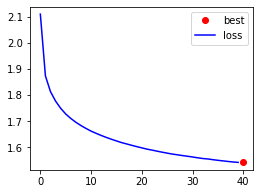

Best epoch so far:  40
Time  157.953 sec

Epoch 41 Batch 598 Loss: 1.3733
Epoch 41 Batch 1196 Loss: 2.0362
Epoch 41 Batch 1794 Loss: 1.9612
Epoch 41 Batch 2392 Loss: 1.8979
Epoch 41 Batch 2990 Loss: 1.5804
Epoch 41 Batch 3588 Loss: 1.8837

*** Epoch 41 Loss 1.5407 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  41
Time  155.867 sec

Epoch 42 Batch 598 Loss: 1.3880
Epoch 42 Batch 1196 Loss: 1.9149
Epoch 42 Batch 1794 Loss: 1.8562
Epoch 42 Batch 2392 Loss: 1.8053
Epoch 42 Batch 2990 Loss: 1.5795
Epoch 42 Batch 3588 Loss: 1.8850

*** Epoch 42 Loss 1.5383 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i a

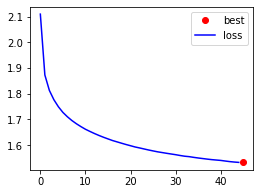

Best epoch so far:  45
Time  158.192 sec

Epoch 46 Batch 598 Loss: 1.4421
Epoch 46 Batch 1196 Loss: 1.9697
Epoch 46 Batch 1794 Loss: 1.8976
Epoch 46 Batch 2392 Loss: 1.8718
Epoch 46 Batch 2990 Loss: 1.4984
Epoch 46 Batch 3588 Loss: 1.9020

*** Epoch 46 Loss 1.5317 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  46
Time  158.752 sec

Epoch 47 Batch 598 Loss: 1.2421
Epoch 47 Batch 1196 Loss: 2.0513
Epoch 47 Batch 1794 Loss: 1.7929
Epoch 47 Batch 2392 Loss: 1.9068
Epoch 47 Batch 2990 Loss: 1.5412
Epoch 47 Batch 3588 Loss: 1.8891

*** Epoch 47 Loss 1.5298 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: W

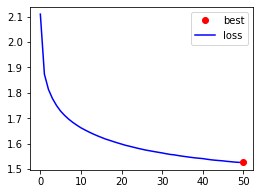

Best epoch so far:  50
Time  158.085 sec

Epoch 51 Batch 598 Loss: 1.4428
Epoch 51 Batch 1196 Loss: 1.9855
Epoch 51 Batch 1794 Loss: 1.8893
Epoch 51 Batch 2392 Loss: 2.0138
Epoch 51 Batch 2990 Loss: 1.5166
Epoch 51 Batch 3588 Loss: 2.0184

*** Epoch 51 Loss 1.5244 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  51
Time  158.779 sec

Epoch 52 Batch 598 Loss: 1.2882
Epoch 52 Batch 1196 Loss: 2.0764
Epoch 52 Batch 1794 Loss: 1.7737
Epoch 52 Batch 2392 Loss: 1.8995
Epoch 52 Batch 2990 Loss: 1.5583
Epoch 52 Batch 3588 Loss: 1.8332

*** Epoch 52 Loss 1.5235 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a matter of coward 
%
Greedy| Q: What are you doing ?  A: 

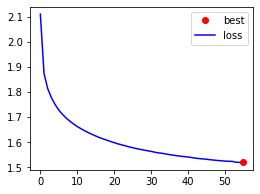

Best epoch so far:  55
Time  158.378 sec

Epoch 56 Batch 598 Loss: 1.4606
Epoch 56 Batch 1196 Loss: 1.9401
Epoch 56 Batch 1794 Loss: 1.8641
Epoch 56 Batch 2392 Loss: 1.9778
Epoch 56 Batch 2990 Loss: 1.5332
Epoch 56 Batch 3588 Loss: 1.8718

*** Epoch 56 Loss 1.5186 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am fine 
####################
check point saved!
Best epoch so far:  56
Time  157.705 sec

Epoch 57 Batch 598 Loss: 1.3528
Epoch 57 Batch 1196 Loss: 2.0115
Epoch 57 Batch 1794 Loss: 1.9224
Epoch 57 Batch 2392 Loss: 1.8878
Epoch 57 Batch 2990 Loss: 1.5484
Epoch 57 Batch 3588 Loss: 1.8486

*** Epoch 57 Loss 1.5161 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a matter of coward 
%
Greedy| Q: What are you doing ?  A:

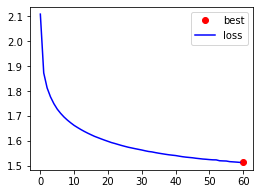

Best epoch so far:  60
Time  157.546 sec

Epoch 61 Batch 598 Loss: 1.4521
Epoch 61 Batch 1196 Loss: 1.8802
Epoch 61 Batch 1794 Loss: 1.8336
Epoch 61 Batch 2392 Loss: 1.9960
Epoch 61 Batch 2990 Loss: 1.5369
Epoch 61 Batch 3588 Loss: 1.8859

*** Epoch 61 Loss 1.5123 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am fine 
####################
check point saved!
Best epoch so far:  61
Time  158.145 sec

Epoch 62 Batch 598 Loss: 1.4247
Epoch 62 Batch 1196 Loss: 1.9369
Epoch 62 Batch 1794 Loss: 1.8560
Epoch 62 Batch 2392 Loss: 1.8671
Epoch 62 Batch 2990 Loss: 1.4758
Epoch 62 Batch 3588 Loss: 1.8748

*** Epoch 62 Loss 1.5125 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: 

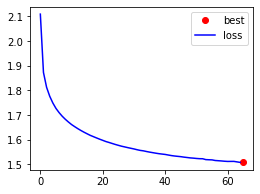

Best epoch so far:  65
Time  158.514 sec

Epoch 66 Batch 598 Loss: 1.4609
Epoch 66 Batch 1196 Loss: 1.7799
Epoch 66 Batch 1794 Loss: 1.8441
Epoch 66 Batch 2392 Loss: 1.9640
Epoch 66 Batch 2990 Loss: 1.4698
Epoch 66 Batch 3588 Loss: 1.7881

*** Epoch 66 Loss 1.5080 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  66
Time  157.744 sec

Epoch 67 Batch 598 Loss: 1.4337
Epoch 67 Batch 1196 Loss: 1.9622
Epoch 67 Batch 1794 Loss: 1.8669
Epoch 67 Batch 2392 Loss: 1.9892
Epoch 67 Batch 2990 Loss: 1.4971
Epoch 67 Batch 3588 Loss: 1.9805

*** Epoch 67 Loss 1.5067 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: 

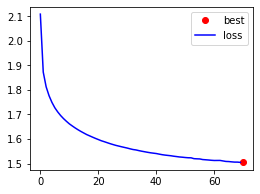

Best epoch so far:  70
Time  157.593 sec

Epoch 71 Batch 598 Loss: 1.4914
Epoch 71 Batch 1196 Loss: 1.7684
Epoch 71 Batch 1794 Loss: 1.8199
Epoch 71 Batch 2392 Loss: 1.9437
Epoch 71 Batch 2990 Loss: 1.3709
Epoch 71 Batch 3588 Loss: 1.7433

*** Epoch 71 Loss 1.5032 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: what 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  71
Time  157.963 sec

Epoch 72 Batch 598 Loss: 1.4575
Epoch 72 Batch 1196 Loss: 1.9117
Epoch 72 Batch 1794 Loss: 1.8439
Epoch 72 Batch 2392 Loss: 1.9423
Epoch 72 Batch 2990 Loss: 1.5198
Epoch 72 Batch 3588 Loss: 1.8474

*** Epoch 72 Loss 1.5033 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your 

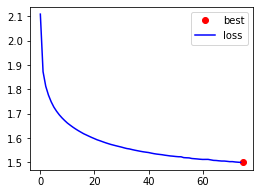

Best epoch so far:  75
Time  158.123 sec

Epoch 76 Batch 598 Loss: 1.5241
Epoch 76 Batch 1196 Loss: 1.7593
Epoch 76 Batch 1794 Loss: 1.7401
Epoch 76 Batch 2392 Loss: 1.9363
Epoch 76 Batch 2990 Loss: 1.3336
Epoch 76 Batch 3588 Loss: 1.6937

*** Epoch 76 Loss 1.5001 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to be a peach farmer 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
####################
check point saved!
Best epoch so far:  76
Time  157.397 sec

Epoch 77 Batch 598 Loss: 1.4449
Epoch 77 Batch 1196 Loss: 1.8559
Epoch 77 Batch 1794 Loss: 1.8238
Epoch 77 Batch 2392 Loss: 1.9670
Epoch 77 Batch 2990 Loss: 1.5261
Epoch 77 Batch 3588 Loss: 1.8502

*** Epoch 77 Loss 1.4993 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Gree

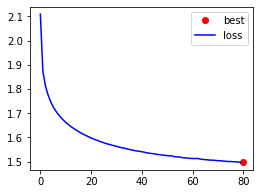

Best epoch so far:  80
Time  158.580 sec

Epoch 81 Batch 598 Loss: 1.4169
Epoch 81 Batch 1196 Loss: 1.6231
Epoch 81 Batch 1794 Loss: 1.5596
Epoch 81 Batch 2392 Loss: 1.7157
Epoch 81 Batch 2990 Loss: 1.3909
Epoch 81 Batch 3588 Loss: 1.3807

*** Epoch 81 Loss 1.4974 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
####################
Best epoch so far:  80
Time  158.498 sec

Epoch 82 Batch 598 Loss: 1.4601
Epoch 82 Batch 1196 Loss: 1.7757
Epoch 82 Batch 1794 Loss: 1.8131
Epoch 82 Batch 2392 Loss: 1.9417
Epoch 82 Batch 2990 Loss: 1.4562
Epoch 82 Batch 3588 Loss: 1.7672

*** Epoch 82 Loss 1.5011 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your

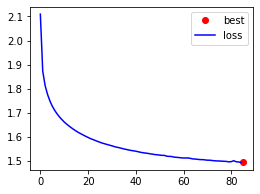

Best epoch so far:  85
Time  158.026 sec

Epoch 86 Batch 598 Loss: 1.3610
Epoch 86 Batch 1196 Loss: 1.6622
Epoch 86 Batch 1794 Loss: 1.5212
Epoch 86 Batch 2392 Loss: 1.7483
Epoch 86 Batch 2990 Loss: 1.3663
Epoch 86 Batch 3588 Loss: 1.4621

*** Epoch 86 Loss 1.4934 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a pair 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am fine 
####################
check point saved!
Best epoch so far:  86
Time  157.866 sec

Epoch 87 Batch 598 Loss: 1.4934
Epoch 87 Batch 1196 Loss: 1.7489
Epoch 87 Batch 1794 Loss: 1.8048
Epoch 87 Batch 2392 Loss: 1.9295
Epoch 87 Batch 2990 Loss: 1.3485
Epoch 87 Batch 3588 Loss: 1.7133

*** Epoch 87 Loss 1.4935 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy

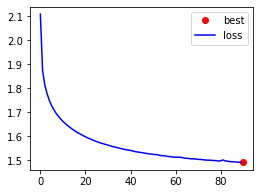

Best epoch so far:  90
Time  158.015 sec

Epoch 91 Batch 598 Loss: 1.3779
Epoch 91 Batch 1196 Loss: 1.6816
Epoch 91 Batch 1794 Loss: 1.4781
Epoch 91 Batch 2392 Loss: 1.7624
Epoch 91 Batch 2990 Loss: 1.3702
Epoch 91 Batch 3588 Loss: 1.5654

*** Epoch 91 Loss 1.4908 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to be a clicks 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i do not know 
%
Greedy| Q: Do you want to go out ?  A: i am not going to saturn to congratulate 
####################
Best epoch so far:  90
Time  158.037 sec

Epoch 92 Batch 598 Loss: 1.4966
Epoch 92 Batch 1196 Loss: 1.7660
Epoch 92 Batch 1794 Loss: 1.6934
Epoch 92 Batch 2392 Loss: 1.9329
Epoch 92 Batch 2990 Loss: 1.3026
Epoch 92 Batch 3588 Loss: 1.6500

*** Epoch 92 Loss 1.4905 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not interested 
%
Greedy| Q: What are you d

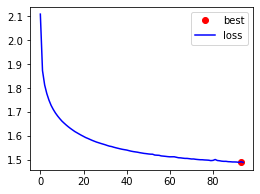

Best epoch so far:  93
Time  158.031 sec

Epoch 96 Batch 598 Loss: 1.3271
Epoch 96 Batch 1196 Loss: 1.7174
Epoch 96 Batch 1794 Loss: 1.5007
Epoch 96 Batch 2392 Loss: 1.8285
Epoch 96 Batch 2990 Loss: 1.4216
Epoch 96 Batch 3588 Loss: 1.5325

*** Epoch 96 Loss 1.4893 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not satisfied 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i do not know 
%
Greedy| Q: Do you want to go out ?  A: i am fine 
####################
Best epoch so far:  93
Time  157.332 sec

Epoch 97 Batch 598 Loss: 1.4085
Epoch 97 Batch 1196 Loss: 1.6337
Epoch 97 Batch 1794 Loss: 1.5603
Epoch 97 Batch 2392 Loss: 1.7246
Epoch 97 Batch 2990 Loss: 1.3658
Epoch 97 Batch 3588 Loss: 1.3404

*** Epoch 97 Loss 1.4884 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What i

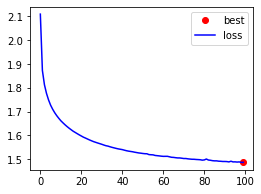

Best epoch so far:  99
Time  157.896 sec

Epoch 101 Batch 598 Loss: 1.2901
Epoch 101 Batch 1196 Loss: 1.7479
Epoch 101 Batch 1794 Loss: 1.6076
Epoch 101 Batch 2392 Loss: 1.8468
Epoch 101 Batch 2990 Loss: 1.4529
Epoch 101 Batch 3588 Loss: 1.6724

*** Epoch 101 Loss 1.4857 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  101
Time  158.055 sec

Epoch 102 Batch 598 Loss: 1.3781
Epoch 102 Batch 1196 Loss: 1.6512
Epoch 102 Batch 1794 Loss: 1.5252
Epoch 102 Batch 2392 Loss: 1.7445
Epoch 102 Batch 2990 Loss: 1.3619
Epoch 102 Batch 3588 Loss: 1.4311

*** Epoch 102 Loss 1.4865 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%


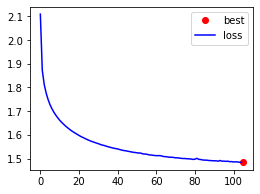

Best epoch so far:  105
Time  157.373 sec

Epoch 106 Batch 598 Loss: 1.3345
Epoch 106 Batch 1196 Loss: 1.8372
Epoch 106 Batch 1794 Loss: 1.7706
Epoch 106 Batch 2392 Loss: 1.7629
Epoch 106 Batch 2990 Loss: 1.4862
Epoch 106 Batch 3588 Loss: 1.7239

*** Epoch 106 Loss 1.4843 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  105
Time  157.688 sec

Epoch 107 Batch 598 Loss: 1.3676
Epoch 107 Batch 1196 Loss: 1.6813
Epoch 107 Batch 1794 Loss: 1.4721
Epoch 107 Batch 2392 Loss: 1.7791
Epoch 107 Batch 2990 Loss: 1.3652
Epoch 107 Batch 3588 Loss: 1.5094

*** Epoch 107 Loss 1.4829 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What i

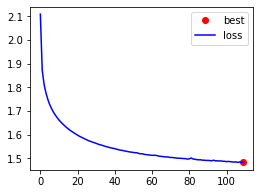

Best epoch so far:  109
Time  158.779 sec

Epoch 111 Batch 598 Loss: 1.2096
Epoch 111 Batch 1196 Loss: 1.9814
Epoch 111 Batch 1794 Loss: 1.7133
Epoch 111 Batch 2392 Loss: 1.8584
Epoch 111 Batch 2990 Loss: 1.4901
Epoch 111 Batch 3588 Loss: 1.8020

*** Epoch 111 Loss 1.4818 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  111
Time  157.947 sec

Epoch 112 Batch 598 Loss: 1.3230
Epoch 112 Batch 1196 Loss: 1.7277
Epoch 112 Batch 1794 Loss: 1.5020
Epoch 112 Batch 2392 Loss: 1.8501
Epoch 112 Batch 2990 Loss: 1.4029
Epoch 112 Batch 3588 Loss: 1.5207

*** Epoch 112 Loss 1.4820 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 


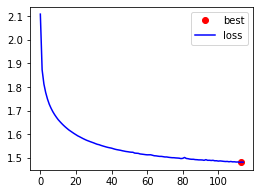

Best epoch so far:  113
Time  157.071 sec

Epoch 116 Batch 598 Loss: 1.2532
Epoch 116 Batch 1196 Loss: 2.0169
Epoch 116 Batch 1794 Loss: 1.7410
Epoch 116 Batch 2392 Loss: 1.8486
Epoch 116 Batch 2990 Loss: 1.5244
Epoch 116 Batch 3588 Loss: 1.7105

*** Epoch 116 Loss 1.4808 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  113
Time  157.639 sec

Epoch 117 Batch 598 Loss: 1.2974
Epoch 117 Batch 1196 Loss: 1.7641
Epoch 117 Batch 1794 Loss: 1.6266
Epoch 117 Batch 2392 Loss: 1.8590
Epoch 117 Batch 2990 Loss: 1.4509
Epoch 117 Batch 3588 Loss: 1.6745

*** Epoch 117 Loss 1.4796 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Gree

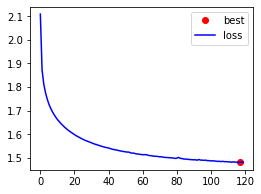

Best epoch so far:  117
Time  160.996 sec

Epoch 121 Batch 598 Loss: 1.3205
Epoch 121 Batch 1196 Loss: 1.9635
Epoch 121 Batch 1794 Loss: 1.8592
Epoch 121 Batch 2392 Loss: 1.8468
Epoch 121 Batch 2990 Loss: 1.5073
Epoch 121 Batch 3588 Loss: 1.7700

*** Epoch 121 Loss 1.4806 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am fine 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  117
Time  165.729 sec

Epoch 122 Batch 598 Loss: 1.3288
Epoch 122 Batch 1196 Loss: 1.8299
Epoch 122 Batch 1794 Loss: 1.7607
Epoch 122 Batch 2392 Loss: 1.7566
Epoch 122 Batch 2990 Loss: 1.5155
Epoch 122 Batch 3588 Loss: 1.7639

*** Epoch 122 Loss 1.4802 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| 

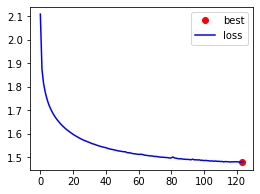

Best epoch so far:  123
Time  204.448 sec

Epoch 126 Batch 598 Loss: 1.3660
Epoch 126 Batch 1196 Loss: 1.8938
Epoch 126 Batch 1794 Loss: 1.8169
Epoch 126 Batch 2392 Loss: 1.8180
Epoch 126 Batch 2990 Loss: 1.4375
Epoch 126 Batch 3588 Loss: 1.8025

*** Epoch 126 Loss 1.4783 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am fine 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  123
Time  203.724 sec

Epoch 127 Batch 598 Loss: 1.2016
Epoch 127 Batch 1196 Loss: 2.0000
Epoch 127 Batch 1794 Loss: 1.7330
Epoch 127 Batch 2392 Loss: 1.8458
Epoch 127 Batch 2990 Loss: 1.4870
Epoch 127 Batch 3588 Loss: 1.7933

*** Epoch 127 Loss 1.4783 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What 

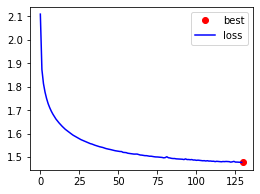

Best epoch so far:  130
Time  162.740 sec

Epoch 131 Batch 598 Loss: 1.3759
Epoch 131 Batch 1196 Loss: 1.9800
Epoch 131 Batch 1794 Loss: 1.8686
Epoch 131 Batch 2392 Loss: 1.9473
Epoch 131 Batch 2990 Loss: 1.4256
Epoch 131 Batch 3588 Loss: 1.9247

*** Epoch 131 Loss 1.4796 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a philosopher 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i do not know 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  130
Time  159.125 sec

Epoch 132 Batch 598 Loss: 1.2530
Epoch 132 Batch 1196 Loss: 2.0386
Epoch 132 Batch 1794 Loss: 1.7190
Epoch 132 Batch 2392 Loss: 1.8380
Epoch 132 Batch 2990 Loss: 1.5035
Epoch 132 Batch 3588 Loss: 1.7432

*** Epoch 132 Loss 1.4769 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am 

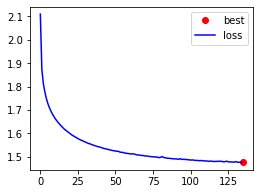

Best epoch so far:  135
Time  158.901 sec

Epoch 136 Batch 598 Loss: 1.3984
Epoch 136 Batch 1196 Loss: 1.8751
Epoch 136 Batch 1794 Loss: 1.8164
Epoch 136 Batch 2392 Loss: 1.9028
Epoch 136 Batch 2990 Loss: 1.4675
Epoch 136 Batch 3588 Loss: 1.7860

*** Epoch 136 Loss 1.4751 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am fine 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  136
Time  159.447 sec

Epoch 137 Batch 598 Loss: 1.3042
Epoch 137 Batch 1196 Loss: 1.9687
Epoch 137 Batch 1794 Loss: 1.8616
Epoch 137 Batch 2392 Loss: 1.8479
Epoch 137 Batch 2990 Loss: 1.4963
Epoch 137 Batch 3588 Loss: 1.7464

*** Epoch 137 Loss 1.4748 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not wewe 
%
Greedy| Q: What are you doing ?  

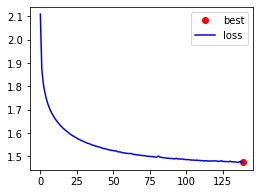

Best epoch so far:  139
Time  160.581 sec

Epoch 141 Batch 598 Loss: 1.4147
Epoch 141 Batch 1196 Loss: 1.8394
Epoch 141 Batch 1794 Loss: 1.7722
Epoch 141 Batch 2392 Loss: 1.9236
Epoch 141 Batch 2990 Loss: 1.4872
Epoch 141 Batch 3588 Loss: 1.8096

*** Epoch 141 Loss 1.4744 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a witch 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i do not know 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  139
Time  159.789 sec

Epoch 142 Batch 598 Loss: 1.3729
Epoch 142 Batch 1196 Loss: 1.9288
Epoch 142 Batch 1794 Loss: 1.8384
Epoch 142 Batch 2392 Loss: 1.8107
Epoch 142 Batch 2990 Loss: 1.4621
Epoch 142 Batch 3588 Loss: 1.7998

*** Epoch 142 Loss 1.4730 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of penicillin 
%
Greedy| Q: What are you doing ?  A:

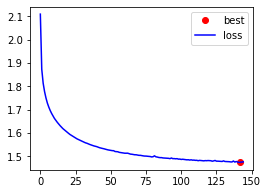

Best epoch so far:  142
Time  159.335 sec

Epoch 146 Batch 598 Loss: 1.4211
Epoch 146 Batch 1196 Loss: 1.7476
Epoch 146 Batch 1794 Loss: 1.7865
Epoch 146 Batch 2392 Loss: 1.9181
Epoch 146 Batch 2990 Loss: 1.4314
Epoch 146 Batch 3588 Loss: 1.7216

*** Epoch 146 Loss 1.4758 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of things 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am fine 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  142
Time  159.853 sec

Epoch 147 Batch 598 Loss: 1.4008
Epoch 147 Batch 1196 Loss: 1.9191
Epoch 147 Batch 1794 Loss: 1.8273
Epoch 147 Batch 2392 Loss: 1.9881
Epoch 147 Batch 2990 Loss: 1.4349
Epoch 147 Batch 3588 Loss: 1.8935

*** Epoch 147 Loss 1.4730 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of repeat 
%
Greedy| Q: What are you

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-147")

In [ ]:
test_bot()


####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not like a lot of repeat 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i do not know 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################


Input: how old are you
Predicted answer: six 


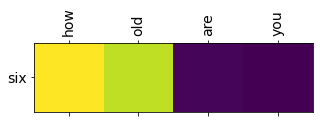

In [ ]:
q = "How old are you"
answer(q, training=False)


Input: do you drink
Predicted answer: no 


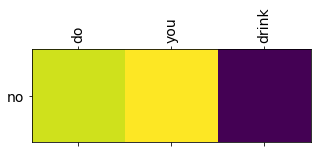

In [ ]:
q = "Do you drink"
answer(q, training=False)


**Task 3** Let's look at the attention weights and compare them after 5, 50 and 140 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following questions based on your predictions, giving examples and/or explaining the evidence for your answers.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?





















You now have a good understanding of how to build a generative conversational model. If you're interested, you can customise the chatbot's behaviour by adjusting the model and training parameters, as well as the data used to train the model.

In [ ]:
def test_bot_final(k = 5, beam = False):
    print('#'*20)
    q = 'How are you'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'Where are you from'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'In which year were you born'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'Should we have more weekends'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Are you going to the party'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'Who is the fastest animal'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What is your favorite movie'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'How many siblings do you have'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'Which is the best football club'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'Do you watch anime'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-147")
test_bot_final()

####################
Greedy| Q: You alright   A: i am fine 
%
Greedy| Q: Where are you from ?  A: i do not know 
%
Greedy| Q: Which year you were born ?  A: i am not 
%
Greedy| Q: When will you come ?  A: i am going to be 
%
Greedy| Q: Are you coming to the party ?  A: i am fine 
%
Greedy| Q: Where is your brain ?  A: in the hospital 
%
Greedy| Q: What is your favorite film ?  A: i am not 
%
Greedy| Q: How many sisters do you have ?  A: three days 
%
Greedy| Q: How is weather today ?  A: i am doing 
%
Greedy| Q: What is the capital city of Turkey ?  A: i do not know 
####################


In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-5")
test_bot_final()

####################
Greedy| Q: You alright   A: i am not 
%
Greedy| Q: Where are you from ?  A: i am sorry 
%
Greedy| Q: Which year you were born ?  A: i am sorry 
%
Greedy| Q: When will you come ?  A: i am not 
%
Greedy| Q: Are you coming to the party ?  A: i am not 
%
Greedy| Q: Where is your brain ?  A: i am sorry 
%
Greedy| Q: What is your favorite film ?  A: i am not 
%
Greedy| Q: How many sisters do you have ?  A: i am not a good time 
%
Greedy| Q: How is weather today ?  A: i am sorry 
%
Greedy| Q: What is the capital city of Turkey ?  A: i am sorry 
####################


In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-50")
test_bot_final()

####################
Greedy| Q: You alright   A: i am fine 
%
Greedy| Q: Where are you from ?  A: i am going to do 
%
Greedy| Q: Which year you were born ?  A: i am not 
%
Greedy| Q: When will you come ?  A: i am not 
%
Greedy| Q: Are you coming to the party ?  A: i am not 
%
Greedy| Q: Where is your brain ?  A: i am not 
%
Greedy| Q: What is your favorite film ?  A: i am sorry 
%
Greedy| Q: How many sisters do you have ?  A: i am not 
%
Greedy| Q: How is weather today ?  A: i am sorry 
%
Greedy| Q: What is the capital city of Turkey ?  A: a medicine 
####################


In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-140")
test_bot_final()

####################
Greedy| Q: You alright   A: i am fine 
%
Greedy| Q: Where are you from ?  A: i do not know 
%
Greedy| Q: Which year you were born ?  A: i am not 
%
Greedy| Q: When will you come ?  A: i am going to be here 
%
Greedy| Q: Are you coming to the party ?  A: i am fine 
%
Greedy| Q: Where is your brain ?  A: i am going to do with emily 
%
Greedy| Q: What is your favorite film ?  A: i am fine 
%
Greedy| Q: How many sisters do you have ?  A: three days 
%
Greedy| Q: How is weather today ?  A: i am sorry 
%
Greedy| Q: What is the capital city of Turkey ?  A: i do not know 
####################
